In [1]:
import gym
import random
import numpy as np
from math import log,floor

We will make use of a Black Jack enviroment implemented as an OpenAI gym enviroment.

In [2]:
env = gym.make("Blackjack-v0")


We define the set of States, Actions and State-Action pairs.

A state will be a tuple (i,j,ace), where i is the value of the player's hand, j the value of the dealer's hand,
and ace is a boolean indicating if the player has a usable ace.

In [3]:
States=[(i,j,ace) for i in range(11,22) for j in range(1,11) for ace in [True,False]]

Actions = [0,1]

State_Actions=[(state,action) for state in States for action in Actions]

This is an implementation of the Monte Carlo algorithm with exploring states to compute and optimal policy,
as described in chapter 5 of Sutton and Barto.

In [4]:
def MC_ES(env,States,Actions,State_Actions,gamma):
    
    #initialize
    policy={state:env.action_space.sample() for state in States}
    Q={state_action:0 for state_action in State_Actions}
    Seen={state_action:0 for state_action in State_Actions}
    Policies=[]
    
    #we will log a copy of the policy each time good(k) is True.
    def good(k): 
        if k==0:
            return True
        a = floor(log(k,10))
        if k % 10**a == 0:
            return True
        else:
            return False
    
    
    for k in range(5*10**7):
        if good(k):
            #print(k,policy,"\n")
            Policies.append((k,policy.copy()))
        
        #generate episode following policy with intial random state and action
        states,actions,rewards = generate_episode(policy,env,States)
        
        states_actions=list(zip(states,actions))
        G=0
        
        for t in reversed(range(len(states))):
            G = gamma*G + rewards[t]
            
            state_action = states_actions[t]
            
            if states_actions.index(state_action)==t: #first occurence MC ES
                Seen[state_action]+=1
                
                Q[state_action]= Q[state_action]+ (G-Q[state_action])/Seen[state_action]
                
                best_so_far = -100
                for action in Actions:
                    if Q[(states[t],action)] > best_so_far:
                        best_so_far=Q[(states[t],action)]
                        best_action = action
                policy[states[t]]=best_action
    return policy,Q,Seen,Policies
                
        
        

In [5]:
def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def generate_episode(policy,env,States):
    
    env.reset()
    
    while sum_hand(env.player) < 12:
        env.step(1)
    
    episode_states,episode_actions,episode_rewards=[],[],[]
    
    episode_states.append(env._get_obs())
    episode_actions.append(env.action_space.sample())
    
    while True:
        
        new_state,reward,done,info = env.step(episode_actions[-1])
        
        episode_rewards.append(reward)
        
        if not done:
            episode_states.append(new_state)
            episode_actions.append(policy[new_state])
        else:
            break
            
        
    return episode_states,episode_actions,episode_rewards
    

In [6]:
policy,Q,Seen,Policies = MC_ES(env,States,Actions,State_Actions,1)

We will create a gif that shows how the policy converges.
    

In [7]:
import itertools
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook


def generate_array(policy):
    usable = np.zeros((10,10))
    not_usable = np.zeros((10,10))
    
    for dealer in range(10):
        for player in range(10):
            usable[player,dealer]=policy[(21-player,dealer+1,True)]
            not_usable[player,dealer]=policy[(21-player,dealer+1,False)]
            
    return usable,not_usable


arrays = [(policy[0],)+generate_array(policy[1]) for policy in Policies]

<IPython.core.display.Javascript object>


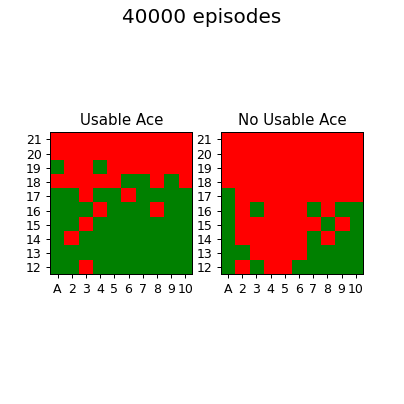

In [8]:
xaxis=["A"]+list(range(2,11))
yaxis=list(range(12,22))
yaxis.reverse()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","green"])

fig = plt.figure(figsize=(5, 5))        
plt.subplot(121)
im1=plt.imshow(arrays[0][1],cmap=cmap)
plt.xticks(np.arange(10),xaxis)
plt.yticks(np.arange(10),yaxis)
plt.title("Usable Ace")

plt.subplot(122)
im2=plt.imshow(arrays[0][2],cmap=cmap)
plt.xticks(np.arange(10),xaxis)
plt.yticks(np.arange(10),yaxis)
plt.title("No Usable Ace")

fig.suptitle('%s episodes' % arrays[0][0], fontsize=16)

def animate_func(i):
#     if i % fps == 0:
#         print( '.', end ='' )
    im1.set_array(arrays[i][1])
    im2.set_array(arrays[i][2])
    fig.suptitle('%s episodes' % arrays[i][0], fontsize=16)
    return [im1,im2]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(arrays),
                               interval = 1000/5, # in ms
                               )

#anim.save('animation.gif', writer='imagemagick')
#uncomment to save (you should install imagemagick)